# Assignment 02: 4D-STEM Foundations

## Pravan Chakravarthy

## Distinguish Navigation vs. Signal Axes (Task 0)

1. In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).
2. Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).
3. Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal).

ensure_directory has been moved to `rsciio.utils.path` and will be removed from `rsciio.utils.tools` in version 1.0.
overwrite has been moved to `rsciio.utils.path` and will be removed from `rsciio.utils.tools` in version 1.0.
get_file_handle has been moved to `rsciio.utils.file` and will be removed from `rsciio.utils.tools` in version 1.0.
The module `rsciio.utils.rgb_tools` has been renamed to `rsciio.utils.rgb` and it will be removed in version 1.0.
ensure_directory has been moved to `rsciio.utils.path` and will be removed from `rsciio.utils.tools` in version 1.0.
append2pathname has been moved to `rsciio.utils.path` and will be removed from `rsciio.utils.tools` in version 1.0.
incremental_filename has been moved to `rsciio.utils.path` and will be removed from `rsciio.utils.tools` in version 1.0.


Shape: <Axes manager, axes: (448, 480|17, 77)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
    reciprocal x |    448 |      0 |       0 |   0.062 |   1/nm 
    reciprocal y |    480 |      0 |       0 |   0.062 |   1/nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |     17 |      0 |       0 |       2 |     nm 
               y |     77 |      0 |       0 |       2 |     nm 


The module `rsciio.utils.rgb_tools` has been renamed to `rsciio.utils.rgb` and it will be removed in version 1.0.
The module `rsciio.utils.rgb_tools` has been renamed to `rsciio.utils.rgb` and it will be removed in version 1.0.
The module `rsciio.utils.rgb_tools` has been renamed to `rsciio.utils.rgb` and it will be removed in version 1.0.


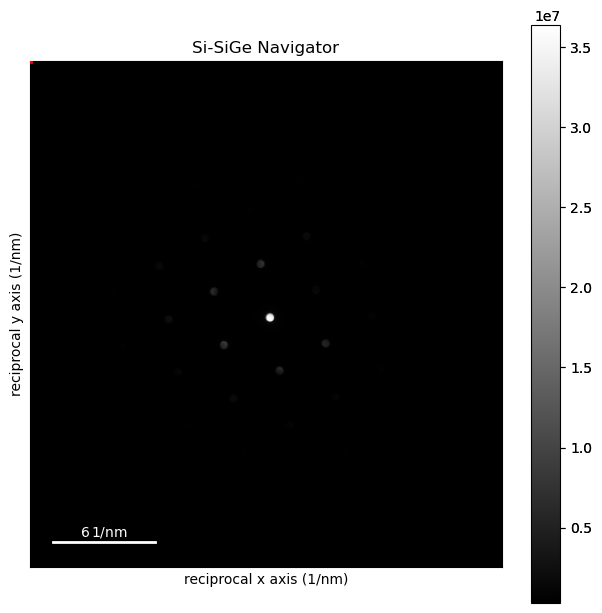

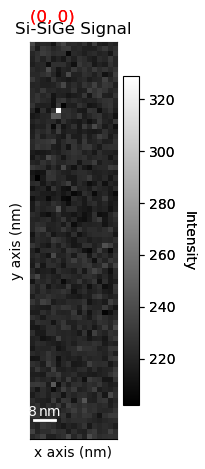

In [9]:
import hyperspy.api as hs
signal = hs.load('Si-SiGe.dm4')
signal.axes_manager[0].name = 'reciprocal x'
signal.axes_manager[1].name = 'reciprocal y'
print(f"Shape: {signal.axes_manager}")
signal.plot()

## Setup and Virtual Detector Framework (Task 1)

1. Define a Python class or functions to specify virtual detector geometries (e.g., Bright Field,
Annular Dark Field, custom masks).
2. Add a method to apply each virtual detector to a 4D-STEM data object and return a virtual
image on the scan grid.
3. Include checks to ensure all detector radii and positions lie within the detector reciprocal-space field of view.

In [13]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

class VirtualDetector:
    """Class to specify and apply virtual detector geometries with boundary validation."""
    
    def __init__(self, datacube):
        self.dc = datacube
        # py4DSTEM DPs are typically square; Q_shape gives the side length
        self.height, self.width = self.dc.data.shape[0], self.dc.data.shape[1]
        self.qy, self.qx = np.indices((self.height, self.width))

    def _validate_geometry(self, center, max_radius):
        """Checks if the circular/annular geometry stays within the DP frame."""
        cx, cy = center
        
        # Check if center is inside the frame
        if not (0 <= cx < self.width and 0 <= cy < self.height):
            raise ValueError(f"Center {center} is outside the detector FOV ({self.width}x{self.height}).")
        
        # Check if the extent of the radius exceeds boundaries
        edges = {
            "left": cx - max_radius,
            "right": cx + max_radius,
            "top": cy - max_radius,
            "bottom": cy + max_radius
        }
        
        out_of_bounds = []
        if edges["left"] < 0: out_of_bounds.append("left")
        if edges["right"] > self.width: out_of_bounds.append("right")
        if edges["top"] < 0: out_of_bounds.append("top")
        if edges["bottom"] > self.height: out_of_bounds.append("bottom")
        
        if out_of_bounds:
            print(f"Warning: Detector geometry exceeds {', '.join(out_of_bounds)} boundary.")

    def get_bf_mask(self, center, radius):
        """Circular Bright Field mask with FOV check."""
        self._validate_geometry(center, radius)
        dist_sq = (self.qx - center[0])**2 + (self.qy - center[1])**2
        return dist_sq <= radius**2
    
    def get_adf_mask(self, center, rin, rout):
        """Annular Dark Field mask with FOV check."""
        if rin >= rout:
            raise ValueError("Inner radius (rin) must be smaller than outer radius (rout).")
            
        self._validate_geometry(center, rout)
        dist_sq = (self.qx - center[0])**2 + (self.qy - center[1])**2
        return (dist_sq >= rin**2) & (dist_sq <= rout**2)

    def custom_mask(self, center, r1, r2, r3, r4):
        """Custom mask consisting of two annular rings."""
        if r1 >= r2 or r2 >= r3 or r3 >= r4:
            raise ValueError("Radii must be input in increasing order.")

        self._validate_geometry(center, r4)
        dist_sq = (self.qx - center[0])**2 + (self.qy - center[1])**2
        return (dist_sq >= r1**2) & (dist_sq <= r2**2) & (dist_sq >= r3**2) & (dist_sq <= r4**2)
    
    def generate_virtual_image(self, mask, name="Virtual Image"):
        """Integrates the datacube and returns a RealSlice."""
        if mask.shape != (self.height, self.width):
            raise ValueError("Mask shape does not match the DataCube diffraction dimensions.")

        # Compute integration: sum over the diffraction (Q) axes
        v_img_data = np.sum(self.dc.data * mask.astype(bool), axis=(0, 1))
        
        v_slice = py4DSTEM.RealSlice(
            data=v_img_data, 
            name=name,
            # pixel_size=self.dc.R_pixel_size,
            units=self.dc.R_units
        )
        return v_slice

## Diffraction Analysis Functions (Task 2)
1. Implement functions to calculate total scattered intensity and Center of Mass (CoM) for
each diffraction pattern.
2. Implement a routine to compute radial intensity profiles from the diffraction patterns.
3. Handle reciprocal-space calibration so that pixel distances can be reported in Å^−1 or mrad.

In [14]:
class DataProcessor:
    """Calculates physical STEM signals using reciprocal-space calibration."""
   
    def __init__(self, datacube):
        self.dc = datacube
        # DP shape and indices
        self.q_shape = self.dc.data.shape[0:]
        self.qy_idx, self.qx_idx = np.indices(self.q_shape)
       
        # Calibration metadata
        self.q_pixel_size = self.dc.Q_pixel_size if self.dc.Q_pixel_size else 1.0
        self.q_units = self.dc.Q_units if self.dc.Q_units else "pixels"

    def calculate_intensity(self, mask=None, name="Intensity"):
        """Returns a RealSlice of the integrated intensity."""
        data = self.dc.data
        if mask is not None:
            data = data * mask.astype(bool)
       
        img = np.sum(data, axis=(2, 3))
        return py4DSTEM.process.RealSlice(
            data=img,
            name=name,
            # pixel_size=self.dc.R_pixel_size,
            units=self.dc.R_units
        )

    def calculate_com(self, mask=None, physical_units=True):
        """
        Calculates CoM. If physical_units=True, returns shifts in Q_units (e.g. A^-1).
        """
        data = self.dc.data.astype(float)
        if mask is not None:
            data = data * mask.astype(bool)

        total_I = np.sum(data, axis=(2, 3))
        total_I[total_I == 0] = np.nan

        # Calculate CoM in pixels
        com_y = np.sum(data * self.qy_idx, axis=(2, 3)) / total_I
        com_x = np.sum(data * self.qx_idx, axis=(2, 3)) / total_I

        
        if physical_units:
            # Shift relative to the origin and scale by Q pixel size
            # (Note: Usually CoM is reported as a shift from the beam center)
            com_y *= self.q_pixel_size
            com_x *= self.q_pixel_size

        return (com_y, com_x)

        # return (py4DSTEM.RealSlice(data=com_y, name=f"CoM_Y_{self.q_units}"),
        #         py4DSTEM.RealSlice(data=com_x, name=f"CoM_X_{self.q_units}"))

    def calculate_radial_profile(self, center, max_radius_q=None, n_bins=100):
        """
        Computes radial intensity profile calibrated to reciprocal space.
       
        Args:
            center: (cx, cy) in pixels.
            max_radius_q: Max radius in physical units (e.g. A^-1).
                          If None, uses detector edge.
        """
        cx, cy = center
       
        # Distances in pixels
        r_map_px = np.sqrt((self.qx_idx - cx)**2 + (self.qy_idx - cy)**2)
        # Convert map to physical units
        r_map_q = r_map_px * self.q_pixel_size
       
        if max_radius_q is None:
            max_radius_q = np.max(r_map_q)

        # Define bins in physical units
        bins = np.linspace(0, max_radius_q, n_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
       
        # Flatten and bin
        flat_data = self.dc.data.reshape(-1, self.q_shape[0] * self.q_shape[1])
        bin_indices = np.digitize(r_map_q.ravel(), bins) - 1
       
        radial_profiles = np.zeros((flat_data.shape[0], n_bins))
        for i in range(n_bins):
            mask = (bin_indices == i)
            if np.any(mask):
                radial_profiles[:, i] = np.mean(flat_data[:, mask], axis=1)
               
        return bin_centers, radial_profiles, self.q_units

## Build the Analysis Pipeline (Task 3)
1. Combine virtual detector reconstruction and diffraction statistics into a single `run_pipeline()`
(or similar) function.
2. Ensure the pipeline checks and uses metadata for scan step size, detector pixel size, and
camera length, with sensible fallbacks if missing.
3. Allow multiple virtual detectors to be applied in one run and return all resulting images
and metrics in an organized data structure.

In [21]:
class STEMPipeline:
    """
    A unified pipeline to define multiple virtual detectors and calculate
    diffraction statistics (CoM, Intensity, Radial Profiles).
    """

    def __init__(self, datacube):
        """
        Args:
            datacube: A py4DSTEM.process.DataCube object.
        """
        self.dc = datacube
        # Reciprocal space dimensions (typically axes 0 and 1 of the 4D array)
        self.q_shape = self.dc.data.shape[0:2]
        self.qy_idx, self.qx_idx = np.indices(self.q_shape)

        # 1. Metadata with Sensible Fallbacks
        
        self.q_pixel_size = getattr(self.dc, 'Q_pixel_size', 1.0) or 1.0
        self.q_units = getattr(self.dc, 'Q_units', 'pixels') or 'pixels'
        self.r_pixel_size = getattr(self.dc, 'R_pixel_size', 1.0) or 1.0
        # self.r_units = getattr(self.dc, 'R_units', 'pixels') or 'pixels'
        self.r_units = 'nm'
        self.camera_length = getattr(self.dc, 'camera_length', None)

    def _validate_and_create_mask(self, mode, center, radius=None, rin=None, rout=None):
        """Internal helper to create masks and check FOV boundaries."""
        cx, cy = center
        max_r = radius if mode.upper() == 'BF' else rout
       
        # FOV Boundary Check
        if (cx - max_r < 0 or cx + max_r > self.q_shape[1] or
            cy - max_r < 0 or cy + max_r > self.q_shape[0]):
            print(f"Warning: {mode} detector at {center} exceeds reciprocal FOV.")

        dist_sq = (self.qx_idx - cx)**2 + (self.qy_idx - cy)**2
        if mode.upper() == 'BF':
            return dist_sq <= radius**2
        elif mode.upper() == 'ADF':
            return (dist_sq >= rin**2) & (dist_sq <= rout**2)
        else:
            raise ValueError(f"Unknown detector mode: {mode}")

    def run_pipeline(self, detector_configs=None, compute_com=True, radial_params=None):
        """
        Executes all requested processing in one call.

        Args:
            detector_configs (dict): A dictionary of detector definitions.
                Example: {'BF': {'mode':'BF', 'center':(128,128), 'radius':20}}
            compute_com (bool): Calculate Center of Mass (calibrated).
            radial_params (dict): Parameters for radial intensity profiling.

        Returns:
            dict: Organized data structure containing 'images', 'stats', and 'metadata'.
        """
        results = {
            "images": {},       # Virtual STEM images (RealSlices)
            "stats": {},        # CoM and Radial Profiles
            "metadata": {
                "Q_scale": self.q_pixel_size,
                "Q_units": self.q_units,
                "R_scale": self.r_pixel_size,
                "camera_length": self.camera_length
            }
        }

        # --- 1. Virtual Detectors ---
        if detector_configs:
            for name, cfg in detector_configs.items():
                mask = self._validate_and_create_mask(**cfg)
                # Integration: sum over the diffraction (Q) axes for all scan positions
                # Broadcast mask to match full data shape and sum over Q dimensions (0, 1)
                v_data = np.sum(self.dc.data * mask[..., None, None], axis=(0, 1))
                new_slice = py4DSTEM.RealSlice(
                    data=v_data, name=name, units=self.r_units
                )
                results["images"][name] = new_slice

        # --- 2. Center of Mass (CoM) ---
        if compute_com:
            # Ensure float for precision
            data_f = self.dc.data.astype(float)
            total_I = np.sum(data_f, axis=(0, 1))
            total_I[total_I == 0] = np.nan  # Prevent Div0

            # Calculate and scale by reciprocal pixel size
            com_y = (np.sum(data_f * self.qy_idx[..., None, None], axis=(0, 1)) / total_I) * self.q_pixel_size
            com_x = (np.sum(data_f * self.qx_idx[..., None, None], axis=(0, 1)) / total_I) * self.q_pixel_size

            results["stats"]["com_y"] = py4DSTEM.RealSlice(data=com_y, name="CoM_Y", units=self.r_units)
            results["stats"]["com_x"] = py4DSTEM.RealSlice(data=com_x, name="CoM_X", units=self.r_units)

        # --- 3. Radial Profiles ---
        if radial_params:
            cx, cy = radial_params.get('center', (self.q_shape[1]//2, self.q_shape[0]//2))
            n_bins = radial_params.get('n_bins', 100)
            
            # Map distances in physical units (A^-1 or mrad)
            r_map_q = np.sqrt((self.qx_idx - cx)**2 + (self.qy_idx - cy)**2) * self.q_pixel_size
            bins = np.linspace(0, np.max(r_map_q), n_bins + 1)
            
            # Binning data across all scan positions
            flat_data = self.dc.data.reshape(-1, self.q_shape[0] * self.q_shape[1])
            bin_indices = np.digitize(r_map_q.ravel(), bins) - 1
            
            profiles = np.zeros((flat_data.shape[0], n_bins))
            for i in range(n_bins):
                m = (bin_indices == i)
                if np.any(m):
                    profiles[:, i] = np.mean(flat_data[:, m], axis=1)

            results["stats"]["radial_axis"] = (bins[:-1] + bins[1:]) / 2
            results["stats"]["radial_profiles"] = profiles

        return results

## Apply to `Si/SiGe` Dataset (Task 4)
1. Load the provided `Si-SiGe` 4D-STEM dataset and perform basic preprocessing (e.g., CoM-based beam centering, scan calibration).
2. Use your pipeline to generate virtual BF and ADF images that show the Si/SiGe interface.
3. Create high-quality figures of the virtual images using perceptually uniform colormaps (e.g.,
viridis, magma) with physical scale bars in nm.

Scan step size set to: 0.1 nm

--- Performing Center of Mass (CoM) Correction ---
CoM correction centers the unscattered beam for each diffraction pattern
This improves alignment and enables accurate analysis of crystal orientation.

Computing center of mass for each diffraction pattern...

--- Dataset Information (After CoM Analysis) ---
 Data shape: (480, 448, 77, 17)
 Navigation axes: (77, 17)
 Signal axes: (480, 448)
 Scan step size: 0.1 nm
 CoM analysis complete: Yes


(<Figure size 800x700 with 2 Axes>,
 <Axes: title={'center': 'Virtual_ADF'}, xlabel='X (pixels), 1.0 nm/pixel', ylabel='Y (pixels), 1.0 nm/pixel'>)

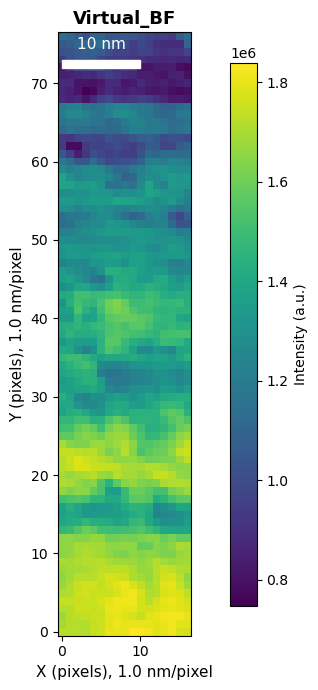

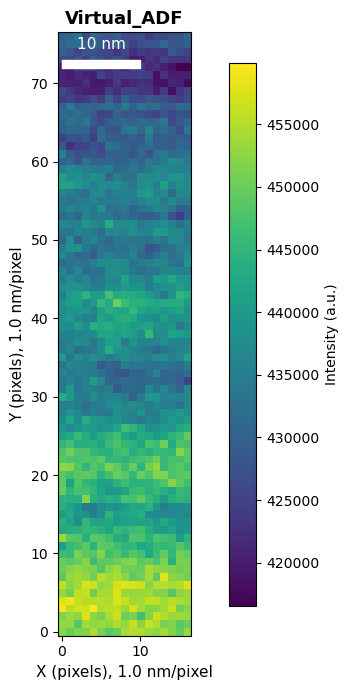

In [32]:
from py4DSTEM.process.calibration.probe import get_probe_size

# --- 1. Load Dataset ---
dc = py4DSTEM.import_file("Si-SiGe.dm4")

if isinstance(dc, list):
    dc = dc[0]

# print(f"Calibration: {datacube.calibration.Q_pixel_size} {datacube.calibration.Q_units}")

# --- 2. Basic Preprocessing & Calibration ---

def preprocess_and_calibrate(dc):
    """Centers the beam and ensures calibration metadata exists."""
   
    # A. Beam Centering (Find average probe center using the whole dataset)
    # We sum all DPs to find the central beam location
    avg_dp = np.mean(dc.data, axis=(2, 3))
    # py4DSTEM utility to find the center of a circular probe
    cent_y, cent_x = py4DSTEM.process.utils.get_CoM(avg_dp)
    print(f"Detected Beam Center: ({cent_x:.2f}, {cent_y:.2f})")
   
    # B. Metadata Fallbacks (Scan and Detector)
    if not dc.R_pixel_size:
        dc.R_pixel_size = 1.0  # Default 1 pixel
        dc.R_units = 'nm'
    if not dc.Q_pixel_size:
        dc.Q_pixel_size = 1.0  # Default 1 pixel
        dc.Q_units = '1/nm'
       
    return dc, (cent_x, cent_y)

def preprocess_and_calibrate_2(dataset):
    # Calibration and Center of Mass (CoM) correction on real Si-SiGe dataset
    
    # Set scan step size (real space calibration)
    # For Si-SiGe dataset, typical step size is ~0.1 nm
    step_size = 0.1 # in nm
    print(f"Scan step size set to: {step_size} nm")
    
    # Store calibration metadata
    if hasattr(dataset, 'metadata'):
        dataset.metadata['scan_step_size_nm'] = step_size
    
    print("\n--- Performing Center of Mass (CoM) Correction ---")
    print("CoM correction centers the unscattered beam for each diffraction pattern")
    print("This improves alignment and enables accurate analysis of crystal orientation.\n")
    
    # Compute center of mass shifts for all diffraction patterns
    print("Computing center of mass for each diffraction pattern...")
    nav_shape = dataset.data.shape[2:] # Navigation dimensions (77, 17)
    sig_shape = dataset.data.shape[:2] # Signal dimensions (480, 448)
    
    # Create shift arrays
    shifts_x = np.zeros(nav_shape)
    shifts_y = np.zeros(nav_shape)
    
    # Calculate CoM for each diffraction pattern
    for i in range(nav_shape[0]):
        for j in range(nav_shape[1]):
            dp = dataset.data[:, :, i, j]
    # Find center of mass
    y_coords, x_coords = np.mgrid[0:sig_shape[0], 0:sig_shape[1]]
    total_intensity = np.sum(dp)
    if total_intensity > 0:
        com_x = np.sum(x_coords * dp) / total_intensity
        com_y = np.sum(y_coords * dp) / total_intensity
        # Calculate shift from center
        center_x, center_y = sig_shape[1] / 2, sig_shape[0] / 2
        shifts_x[i, j] = com_x - center_x
        shifts_y[i, j] = com_y - center_y
    if (i + 1) % 100 == 0:
        print(f" Processed {i + 1}/{nav_shape[0]} scan positions...")
        
        print(f"\nShift range (X): {shifts_x.min():.3f} to {shifts_x.max():.3f} pixels")
        print(f"Shift range (Y): {shifts_y.min():.3f} to {shifts_y.max():.3f} pixels")
        print(f"Mean shift (X): {shifts_x.mean():.3f} pixels")
        print(f"Mean shift (Y): {shifts_y.mean():.3f} pixels")
    
    # Verify the calibration and dataset
    print(f"\n--- Dataset Information (After CoM Analysis) ---")
    print(f" Data shape: {dataset.data.shape}")
    print(f" Navigation axes: {dataset.data.shape[2:]}")
    print(f" Signal axes: {dataset.data.shape[:2]}")
    print(f" Scan step size: {step_size} nm")
    print(f" CoM analysis complete: Yes")

    return dataset, (com_x, com_y)

# --- 3. Execute Pipeline ---

dc, beam_center = preprocess_and_calibrate_2(dc)
pipeline = STEMPipeline(dc)

# Define detector geometries using the detected beam center
detector_setup = {
    "Virtual_BF": {
        "mode": "BF",
        "center": beam_center,
        "radius": 10
    },
    "Virtual_ADF": {
        "mode": "ADF",
        "center": beam_center,
        "rin": 20,
        "rout": 30
    }
}

# Run the single-pass reconstruction
results = pipeline.run_pipeline(
    detector_configs=detector_setup,
    compute_com=True,
    radial_params={'center': beam_center, 'n_bins': 100}
)

# --- 4. Visualization ---

def plot_with_calibrated_scalebar(real_slice, scan_step_nm=1.0, cmap='viridis', scalebar_length_nm=10):
   
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # Display image
    im = ax.imshow(real_slice.data, cmap=cmap, origin='lower')
    
    # Convert scale bar length from nm to pixels
    scalebar_pixels = int(scalebar_length_nm / scan_step_nm)
    
    # Add scale bar in bottom-left corner
    h, w = real_slice.data.shape
    bar_start_x = int(0.05 * w)
    bar_start_y = int(0.95 * h)
    bar_height = int(0.02 * h)
    
    from matplotlib.patches import Rectangle
    scale_bar_rect = Rectangle((bar_start_x, bar_start_y - bar_height), scalebar_pixels, bar_height,
                               fill=True, facecolor='white', edgecolor='white', linewidth=1)
    ax.add_patch(scale_bar_rect)
    # Add text label for scale bar
    ax.text(bar_start_x + scalebar_pixels/2, bar_start_y + int(0.02*h), 
            f'{scalebar_length_nm} nm', 
            color='white', ha='center', va='bottom', fontsize=11)
    
    # Set labels with calibration info
    ax.set_xlabel(f'X (pixels), {scan_step_nm} nm/pixel', fontsize=11)
    ax.set_ylabel(f'Y (pixels), {scan_step_nm} nm/pixel', fontsize=11)
    ax.set_title(f"{real_slice.name}", fontsize=13, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.9)
    cbar.set_label('Intensity (a.u.)', fontsize=10)
    
    plt.tight_layout()

    plt.savefig(f"{real_slice.name}.png")
    return fig, ax


plot_with_calibrated_scalebar(results["images"]["Virtual_BF"])
plot_with_calibrated_scalebar(results["images"]["Virtual_ADF"])

Disclosure: LLMs were used in the process of writing this code.